## 0) Use Casino3 software

In this first demo I use a PSF from Casino3 to expose a demo pattern.

The Casino3 software can be downloaded here http://www.gel.usherbrooke.ca/casino/. You have to register to download

The demo sample is a 200nm PMMA resist layer on a GaN 850 nm on Sapphire substrate. For this example I use 1e7 electrons with 20kV of accelerate voltage and the options are:

    no generate secondary electrons,
    1nm beam diameter,
    100 mrad beam semi-angle
    1.65 gaussian beam distribution.
    cartesian distribution for data
    ...

more parameters are in the sample file _PMMA200_GaN850_Sapphire.sim_ given with this demo.

The PSF is saved in _pmma_1e7_20kV_100mrad_1pt.dat_ file. This file will be used in this example.

## I) Building the PSF data
We will get at the end of this section a 2D matrix data with the psf at the center. Here are the steps to do:

1. Decide the hardware parameters you want to use: the beam energy, the beam current. And the physical properties of your sample.
2. Get the interaction between the electron beam and your sample. You can do it by experiment or by monte-carlo simulation like [Casino3](http://www.gel.usherbrooke.ca/casino/). We call it the *psf function*.
3. Map the *psf function* to a 2D matrix of size equals to the writefield you want to simulate. We call it the *PSF data*.
### I-1) Setup the electron beamer
We use a *Zeiss Supra40* SEM with `20 kV` and the `7.5 µm` aperture

In [16]:
from pecebl.sem import supra40 as beamer

meb = beamer.Supra40(20) #we use a sem Zeiss Supra40 at 20kV
meb.change_aperture(7.5) #use the 7.5 µm aperture
meb.info()

SEM info:
current aperture size: 7.5 µm
current voltage: 20 kV
beam current: 16 pA



### I-2) Import simulated data from Casino3

Monte-Carlo data: import psf file _zep520_1e7_30kV_100mrad_1pt_ from Casino3

In [17]:
from pecebl.psf_import.casino import Casino3 as cs3

sim=cs3('data/pmma_1e7_20kV_100mrad_1pt.dat') #data from Casino3 software

The number of electron paths simulated in Casino3 was `1e7`. The beam writer Raith Elphy Plus has `6 MHz` of electronic speed.
`i_y` for locating at the peak of the psf and `i_z` for placing at the middle depth of the ebeam resist. In this example, I use **Casino3** in a grid size of `(x=8000, y=0.6, z=210)` in *nm* divided by `(nx=8000, ny=6, nz=6)` dots, hence `i_y=3` and `i_z=3`. Now we can get the `psf_fct`:

In [18]:
from pecebl.utils import *

psf_fct=get_psf_fct(1e7, sim, 6, meb.beam_current, i_y=3, i_z=3)

# print the min, max  and mean values:
log_message = f'min value = {np.min(psf_fct[:,1])}; mean value = {np.mean(psf_fct[:,1])}; max value = {np.max(psf_fct[:,1])}.'
print(log_message)

min value = 0.0; mean value = 0.0003472192667973544; max value = 0.2360721816227245.


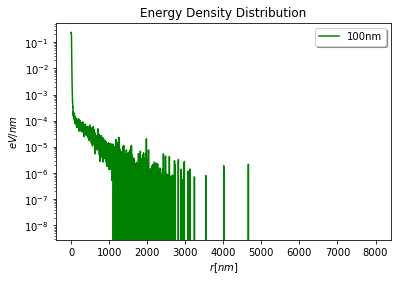

In [19]:
#let's see what look-like the pre-PSF at 100 nm depth of the ebeam resist:
plt.semilogy(psf_fct[:,0],psf_fct[:,1],'g-',label='100nm')
plt.title('Energy Density Distribution');
plt.xlabel('$r[nm]$')
plt.ylabel('$eV/nm$')
plt.legend(loc='upper right', shadow=True)
plt.show()

### I-3) Building the PSF:

In this demo we do with `WF = 5 µm` (writefield) just bigger than the the pattern size (4 µm)

`NP` is the number of pixels, `WF` is the writefield *(nm)*. We can calculate the `pixel_size` then map the two columns data `psf_fct` to a 2D matrix `z_psf` of size *(WF, WF)* $(nm^2)$ (or *(NP, NP)* $(pixel^2)$):

pixel size:  6.4453125
z_PSF created on GPU in 0.322127 s
min value = 0.0; max value = 0.23180298941579333; sum value = 4.81015004684913.
  Total Memory: 2048 MiB
  Free Memory: 1432 MiB


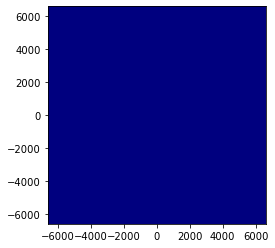

In [20]:
# number of pixels and WF:
NP=2048;
WF = 13200 #for example2

pixel_centered=True #True: (0,0) is in the [NP/2,NP/2] location.
pixel_size=np.float32(WF/NP) if pixel_centered else np.float32(WF/(NP-1))
print('pixel size: ', pixel_size)

#to avoid
#RuntimeError: Numba cannot operate on non-primary CUDA context
#when using pycuda.

if 'pycuda_used' in locals():
    if pycuda_used:
        fft.cudadriver.Context.pop()

from pecebl.ebl_kernels import kernels as ker
from pecebl.designer import designer as pg

z_psf=ker.build_psf(psf_fct, NP, WF, pixel_size, pg.dot(0,0)[0], blockdim=(32,16))
numba_used = True

#plot PSF:
plt.imshow(z_psf,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

## II) Create an pattern : metasurface

In [21]:
corner_1=(-122250,-122500);corner_2=(120800,122500) #for real size 250 µm²
# 2 elements:
w2=[639.7,119.6];d2=[428.6,133.4]
# 3 elements:
w3=[133.4,214.3,618.6];d3=[140.7,105.1,109.2]
# 4 elements:
w4=[156.4,295.4,211.8,184.2];d4=[174.4,115.2,90.1,93.3]
# 5 elements:
w5=[146.2,236.9,90,98.2,161.5];d5=[175.3,93.4,111.2,102.2,106.3]
# 6 elements:
w6=[177.9,151.9,134.1,120.9,90.1,106.1];d6=[90.2,90.3,89.7,90.1,90.1,90.2]

W, H:  11894.4 11895.0


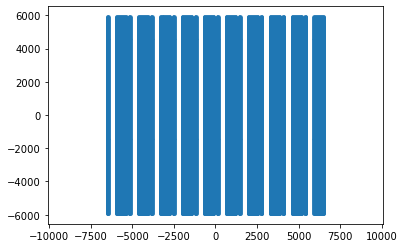

In [22]:
#example2
ss=20;
T=sum(w6)+sum(d6)
n=10
W=(n-1)*T;H=np.ceil(W)
print("W, H: ", W, H)
corner1=[-W/2,-H/2];corner2=[W/2,H/2]

final_pattern=pg.metasurface1(ss,w2,d2,[-W/2,-H/2],[W/2,H/2],n)
plt.plot(final_pattern[:,0], final_pattern[:,1], 'o', ms=1)
plt.axis('equal');plt.show()

### 3-3) Building the dose distribution:

*dose_dis* is the initial dose distribution for this demo pattern. Dose factor = 1 at each dot of the pattern.

In [23]:
from sympy.ntheory import primefactors, factorint

factorint(final_pattern.shape[0]), primefactors(final_pattern.shape[0])

({2: 6, 5: 2, 149: 1}, [2, 5, 149])

In [24]:
final_pattern.shape, 2**6*5**2*149 #for example2

((238400, 3), 238400)

In [25]:
#we cut the final_pattern into grid of blocks size:
5**2,2**4,149,2**2 #for example2

(25, 16, 149, 4)

Dose calculated on GPU in 0.112227 s
overlap = 0.0. Negative value = lost dose.
1.0 1.0
  Total Memory: 2048 MiB
  Free Memory: 1395 MiB


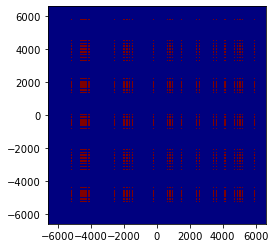

In [26]:
dose_dis = ker.build_dose_distribution(final_pattern, NP, WF, pixel_size, blockdim=(25,16), griddim=(149,4))

# Let's exposure at 30 µC/cm²:
dose_dis *= dtfactor(30,ss,meb.beam_current)

plt.imshow(dose_dis,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

## III) Simulation of ebeam exposure
### III-1) Padding the PSF
PSF kernel need to be expanded to image (expo) size and padded according to **Victor Podlozhnyuk**'s white paper *FFT-based 2D  convolution*: PSF data and resulting exposure data have the same size

In [27]:
#padded psf prior to fft tansform:
ppsf=np.empty((NP,NP),np.float64)
ppsf[:NP//2-1,NP//2+1:]=z_psf[NP//2+1:,:NP//2-1]
ppsf[:NP//2-1,:NP//2+1]=z_psf[NP//2+1:,NP//2-1:]
ppsf[NP//2-1:,:NP//2+1]=z_psf[:NP//2+1,NP//2-1:]
ppsf[NP//2-1:,NP//2+1:]=z_psf[:NP//2+1,:NP//2-1]

del z_psf

### III-2) Exposure using FFT convolution

Convolution by FFT principe:
 - apply direct FFT to the convolution kernel (padded)
 - apply direct FFT to the input data array (or image)
 - perform the point-wise multiplication of the two preceding results
 - apply inverse FFT to the result of the multiplication
 
We have the PSF and the dose distribution, we can do a FFT convolution to expose our pattern: 

GPU : FFT(psf) = psf in-place fft..
GPU : FFT(dose_pc) = dose_dis in-place fft..
GPU : point-wise multiplication of two matrices...
GPU : inverse FFT to get exposure energy distribution...
convolution done on GPU in 3.962455 s
59.8 % of device memory is free.
62.9 % of device memory is free.
1.281621806486987 -1.6361183483008842e-14 20.685792017523973 1.7216877205574604e-14


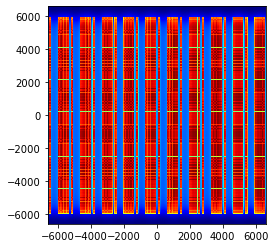

In [28]:
#to avoid
#LogicError: explicit_context_dependent failed: invalid device context - no currently active context?
#when reuse pycuda after using numba cuda.

from pycuda.tools import make_default_context

if 'numba_used' in locals() and 'pycuda_used' in locals():
    if numba_used and pycuda_used:
        make_default_context()

from pecebl.fft_ops import fft_ops as fft

z = fft.fft_exposure(ppsf, dose_dis)
pycuda_used = True

print(np.min(z.real),np.min(z.imag),np.max(z.real),np.max(z.imag))

plt.imshow(z.real,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

## IV) Develop
- a clearing dose 12 eV/nm with step size 4 nm give resist threshold = 3 eV

In [29]:
#z *= 1 #dose increase x times
np.min(z.real),np.mean(z.real), np.max(z.real),np.min(z.imag),np.max(z.imag)

(1.281621806486987,
 12.303183007859579,
 20.685792017523973,
 -1.6361183483008842e-14,
 1.7216877205574604e-14)

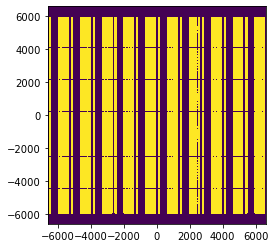

In [30]:
th_resist=12 #clearing dose = 3 eV
z_dev = (z.real> th_resist) * z.real

z_dev[z_dev > 0] = 1

plt.imshow(z_dev,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2]);plt.show()

In [16]:
import imageio

filename='R48_D30_30kV_th_3.png'
imageio.imwrite(filename, z_dev) #save image to filename

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


## V) 3D view with pyopengl

may take a while to display

In [17]:
import sys
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph as pg
import pyqtgraph.opengl as gl

In [18]:
app = QtGui.QApplication([])

In [19]:
x=np.linspace(-WF/2,WF/2,NP)
y=np.linspace(-WF/2,WF/2,NP)

#3D GL view:
w = gl.GLViewWidget()
w.show()
w.setWindowTitle('Expo EBL: ')
w.setCameraPosition(distance=50)

## Add a grid to the view
g = gl.GLGridItem()
g.scale(1,1,1)
g.setDepthValue(1)  # draw grid after surfaces since they may be translucent
w.addItem(g)

cmap=plt.get_cmap('jet')
minZ=np.min(z.real);maxZ=np.max(z.real)
rgba_img=cmap((z.real-minZ)/(maxZ-minZ))

## Simple surface plot example
p1 = gl.GLSurfacePlotItem(x,y,z.real, colors=rgba_img)
#p1.translate(0, 0, -np.mean(z))
w.addItem(p1)

if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
    QtGui.QApplication.instance().exec_()